# IBM Open Science Prize 2022 

**Group:** _Stefan Sack, Stefano Barison_

In [1]:
## TODO: little introduction?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1 - Classical simulation 

In [2]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [3]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

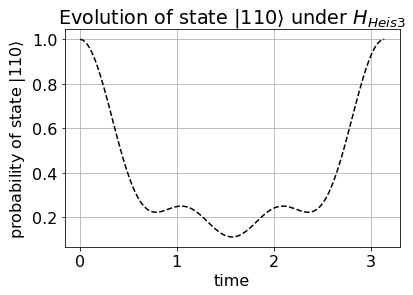

In [4]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

## 2- The Open Science Prize

The aim is to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$).

### 2.1 - Trotterization comparison

For this reason, we will start analysing how a Trotterization on a perfect quantum device will evolve the state $|110\rangle$ to time $t=\pi$ given a fixed number of Trotter steps.

In [5]:
## Import functions from Qiskit
from qiskit                     import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer       import QasmSimulator
from qiskit.tools.monitor       import job_monitor
from qiskit.circuit             import Parameter, ParameterVector
from qiskit.quantum_info        import Statevector, Pauli
from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import PauliOp, SummedOp, CircuitSampler, StateFn

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info                  import state_fidelity

In [6]:
## In the "trotter_function.py" file are contained all the functions useful for a perfect Trotter simulation
from trotter_functions import Heisenberg_Trotter, Heisenberg_Trotter_compressed

In [7]:
## Let's simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
t_steps = [4,8,12]
probs_110_trott = {4:[],8:[],12:[]}
t = Parameter("t")

for t_n in t_steps:
    for sim_t in ts:
        # Initialise the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_step = Heisenberg_Trotter(num_qubits=3,trotter_steps=t_n,p=t,target_time=sim_t).to_instruction()
        trott_qc.append(trott_step, [trott_qr[0], trott_qr[1], trott_qr[2]])
    
    
        trott_wfn = CircuitStateFn(trott_qc)
        trott_ovp = np.abs((~initial_state@trott_wfn).eval())**2
        probs_110_trott[t_n].append(trott_ovp)
    print(str(t_n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


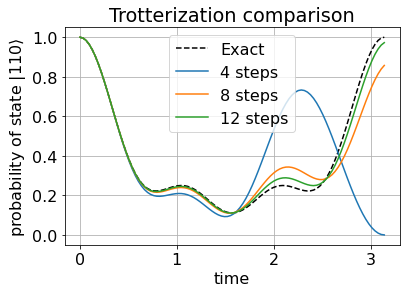

In [8]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i),label=str(t_n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, four Trotter steps are not enough to correctly time evolve the target state to $t=\pi$.
As expected, increasing the Trotter steps we get closer and closer to the exact simulation.

However, we are limited in the circuit depth that we can implement on hardware. For this reason, the aim of this notebook will be to compress the greatest Trotterization accuracy into the shortest possible circuit, before even applying error mitigation techniques.

### 2.2 Compress the Trotter step

The first step is to reduce the number of gates required by a single Trotter step. 
To this point, a single Trotter step requires $12$ CNOTs.

We can easily reduce it to $6$ using an optimal circuit for the $XX+YY+ZZ$ rotation presented in [Quantum computers as universal quantum simulators: state-of-art and perspectives](https://arxiv.org/abs/1907.03505).

In particular, we will consider the decomposition in Fig. 4b, while the initial Trotterization corresponds to the decomposition in Fig. 4a.

With this decomposition, 4 Trotter steps on 3 qubits will now require 24 CNOTs instead of 48.

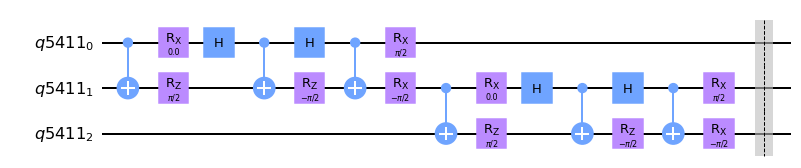

In [13]:
## Ad an example of the new Trotter step

compression_example = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=1,p=t,target_time=np.pi/4)

compression_example.decompose().decompose().draw(output='mpl')

To show that the two decompositions are equivalent, let us simulate again the system up to $t=\pi$.

In [9]:
probs_110_trott_c = []
for sim_t in ts:
    # Initialise the circuit
    trott_qr_c = QuantumRegister(3)
    trott_qc_c = QuantumCircuit(trott_qr_c)
    trott_qc_c.x([1,2])
    
    # Append the Trotterization
    trott_step_c = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,p=t,target_time=sim_t).to_instruction()
    trott_qc_c.append(trott_step_c, [trott_qr_c[0], trott_qr_c[1], trott_qr_c[2]])
    
    
    trott_wfn_c = CircuitStateFn(trott_qc_c)
    trott_ovp_c = np.abs((~initial_state@trott_wfn_c).eval())**2
    probs_110_trott_c.append(trott_ovp_c)

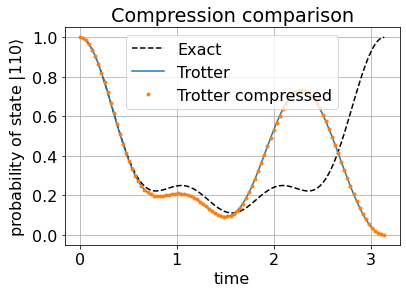

In [56]:
## Now plot the exact simulation, the initial Trotter and the Trotter compressed
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott[4],color="C0",label="Trotter")
plt.plot(ts, probs_110_trott_c,color="C1",marker=".",linestyle="",label="Trotter compressed")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Compression comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, the two circuits give the exact same probability at all times!

### 2.3 Variational compression - the pVQD algorithm

We want to compress more Trotter steps into the same circuit, in order to gain accuracy without adding noise due to gate error rates. This can be done by making every value of $t$ of the Trotter circuit a variational parameter and using the pVQD algorithm optimize them.

We highlight that we are not modifying the circuit, instead we are optimizing the same gates in order to make the circuit contain a more accurate state.

In [36]:
# import the function for pVQD
from pVQD import compute_overlap_and_gradient, adam_gradient, projector_zero, measure_overlap_pVQD, ei

In [15]:
# Here we put a function that creates the same circuit as the Trotter compressed circuit, but with every rotation
# as a variational parameter

def Heisenberg_Trotter_variational(num_qubits,trotter_steps,p):

    circ = QuantumCircuit(num_qubits)
    count = 0

    circ.x([1,2])

    for d in range(trotter_steps):
        for i in range(num_qubits-1):
            circ.cx(i,i+1)
            circ.rx(p[count],i)
            circ.rx(-np.pi/2,i)
            circ.h(i)
            circ.rz(p[count+1],i+1)

            circ.cx(i,i+1)
            circ.h(i)
            circ.rz(p[count+2],i+1)

            circ.cx(i,i+1)
            circ.rx(np.pi/2,i)
            circ.rx(-np.pi/2,i+1)

            count += 3

    return circ

Since we have $3$ rotations depending on $t$ for every compressed gate, this will result in a total of 24 parameters to optimize

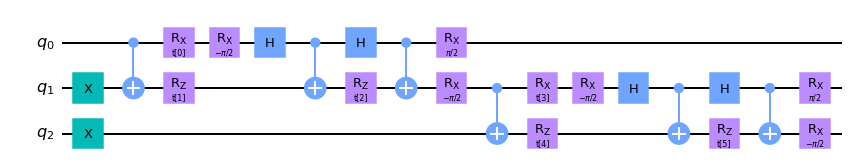

In [17]:
# Here we show an example of the circuit
example = Heisenberg_Trotter_variational(3,1,ParameterVector('t',6))
example.draw(output='mpl')

The circuit has exactly the same gates has before (in this case we also show the initial state $|110\rangle$).

In [18]:
# Here we put the optimization loop of the pVQD algorithm
backend       = Aer.get_backend('statevector_simulator')
instance      = QuantumInstance(backend=backend)
trotter_steps = 4
num_qubits    = 3

parameters    = np.zeros(3*(trotter_steps)*(num_qubits-1))
shift         = 0.01*np.ones(3*(trotter_steps)*(num_qubits-1))
params_vec    = ParameterVector('p',len(parameters))


dt            = np.pi/60
max_iter      = 100
n_steps       = 60
ths           = 0.9999



## Initialize quantities that will be equal all over the calculation
num_parameters = len(parameters)
# ParameterVector for left and right circuit

left  = ParameterVector('l', num_parameters)
right = ParameterVector('r', num_parameters)


## initialize useful quantities once
expectation = PauliExpectation()
sampler     = CircuitSampler(instance)

## Now prepare the state in order to compute the overlap and its gradient
# First use a single compressed Trotter step
U_dt      = Heisenberg_Trotter_compressed(num_qubits,1,t,dt)
ansatz    = Heisenberg_Trotter_variational(num_qubits,trotter_steps,params_vec)

# Then, create the total circuit

l_circ     = ansatz.assign_parameters({params_vec: left})
r_circ     = ansatz.assign_parameters({params_vec: right})
zero_prj   = StateFn(projector_zero(U_dt.num_qubits),is_measurement = True)
total_circ = r_circ.compose(U_dt)+l_circ.inverse()
state_wfn  = expectation.convert(zero_prj @ StateFn(total_circ))

#######################################################

In [19]:
times = [i*dt for i in range(n_steps+1)]
tot_steps= 0
print("Running the algorithm")

pvqd_params = []
pvqd_params.append(list(parameters))


for i in range(n_steps):

    print('\n================================== \n')
    print("Time slice:",i+1)
    print("Shift before optimizing this step:",shift)
    print("Initial parameters:", parameters)
    print('\n================================== \n')

    count = 0
    overlap = [0.01,0]

    # Initialise quantities for the Adam optimiser
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)


    while overlap[0] < ths and count < max_iter:
        print("Shift optimizing step:",count+1)
        count = count +1 

        ## Measure energy and gradient

        E,g = compute_overlap_and_gradient(left,right,state_wfn,parameters,shift,expectation,sampler)
        tot_steps = tot_steps+1


        print('Overlap',E[0])
        overlap = E
        #print('Gradient',g[:,0])


        meas_grad = np.asarray(g[:,0])
        shift = np.asarray(adam_gradient(parameters,shift,count,m,v,meas_grad))


    # Update parameters

    print('\n---------------------------------- \n')

    print("Shift after optimizing:",shift)
    print("New parameters:"        ,parameters + shift)
    print("New overlap: "          ,E[0])

    parameters = parameters + shift
    pvqd_params.append(list(parameters))

Running the algorithm


Time slice: 1
Shift before optimizing this step: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Initial parameters: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Shift optimizing step: 1
Overlap 0.9875054669458878
Shift optimizing step: 2
Overlap 0.9886127324931264
Shift optimizing step: 3
Overlap 0.9896556489361141
Shift optimizing step: 4
Overlap 0.9906332111276291
Shift optimizing step: 5
Overlap 0.9915447702118284
Shift optimizing step: 6
Overlap 0.9923901427422493
Shift optimizing step: 7
Overlap 0.9931697091126361
Shift optimizing step: 8
Overlap 0.9938845114507763
Shift optimizing step: 9
Overlap 0.9945363400995013
Shift optimizing step: 10
Overlap 0.9951277908725215
Shift optimizing step: 11
Overlap 0.995662270241391
Shift optimizing step: 12
Overlap 0.996143925159339
Shift optimizing step: 13
Overlap 0.9965774820405247
Shift optimizing step: 14
Over

Overlap 0.9999095849075765

---------------------------------- 

Shift after optimizing: [ 0.02595628  0.01       -0.00595628  0.02205659  0.02859677 -0.01752424
  0.03499242  0.01093997 -0.01355687  0.02285505  0.02594058 -0.02228317
  0.04325111  0.01187335 -0.02150539  0.02373714  0.02392142 -0.02432645
  0.04437674  0.02194477 -0.02352473  0.02460253  0.0223396  -0.02628765]
New parameters: [ 0.08667265  0.03       -0.02667265  0.04538303  0.10401455 -0.03643539
  0.10472637  0.05323957 -0.04186109  0.04773382  0.09621034 -0.04584764
  0.12121772  0.05337163 -0.05774436  0.05024097  0.0903126  -0.05182276
  0.12542794  0.07302132 -0.06376307  0.05270315  0.08568687 -0.05762595]
New overlap:  0.9999095849075765


Time slice: 4
Shift before optimizing this step: [ 0.02595628  0.01       -0.00595628  0.02205659  0.02859677 -0.01752424
  0.03499242  0.01093997 -0.01355687  0.02285505  0.02594058 -0.02228317
  0.04325111  0.01187335 -0.02150539  0.02373714  0.02392142 -0.02432645
  0.04

Overlap 0.9998939806027387
Shift optimizing step: 2
Overlap 0.999897963465794
Shift optimizing step: 3
Overlap 0.9999126363972703

---------------------------------- 

Shift after optimizing: [ 0.02512418  0.01       -0.00512418  0.02539821  0.02266683 -0.01366296
  0.03432963  0.01864343 -0.01283408  0.02662011  0.02198153 -0.02542895
  0.04228273  0.01984424 -0.02051004  0.0279054   0.02538645 -0.02692487
  0.04147493  0.02993044 -0.02206021  0.02891549  0.02627345 -0.02633727]
New parameters: [ 0.23858202  0.09       -0.05858202  0.19605635  0.26470567 -0.1227596
  0.31101979  0.14075878 -0.1194809   0.20362501  0.24874487 -0.1956768
  0.37675664  0.14751138 -0.1827818   0.21182904  0.23629057 -0.21337713
  0.38578603  0.22764846 -0.20044653  0.21962752  0.22663232 -0.2283996 ]
New overlap:  0.9999126363972703


Time slice: 10
Shift before optimizing this step: [ 0.02512418  0.01       -0.00512418  0.02539821  0.02266683 -0.01366296
  0.03432963  0.01864343 -0.01283408  0.02662011  

Overlap 0.9998659466217702
Shift optimizing step: 2
Overlap 0.9998994814386899
Shift optimizing step: 3
Overlap 0.9999171999530224

---------------------------------- 

Shift after optimizing: [ 0.01930911  0.01        0.00069089  0.01164635  0.02131718 -0.0266116
  0.02633683  0.00716129 -0.00496692  0.03632851  0.02572803 -0.02635954
  0.02902702  0.02889618 -0.01323957  0.04238203  0.04047049 -0.02654567
  0.02345088  0.03698954 -0.0299191   0.04616818  0.03922113 -0.03344744]
New parameters: [ 0.37087183  0.15       -0.07087183  0.30781198  0.37281414 -0.24302897
  0.49589208  0.22256767 -0.17456562  0.38949599  0.37352869 -0.34397216
  0.58803552  0.31665699 -0.28219197  0.42645065  0.43879178 -0.36383523
  0.56962763  0.4556389  -0.34444094  0.45450492  0.44556555 -0.3989254 ]
New overlap:  0.9999171999530224


Time slice: 16
Shift before optimizing this step: [ 0.01930911  0.01        0.00069089  0.01164635  0.02131718 -0.0266116
  0.02633683  0.00716129 -0.00496692  0.03632851 

Overlap 0.9998829751306761
Shift optimizing step: 2
Overlap 0.9999443526108172

---------------------------------- 

Shift after optimizing: [ 0.02351985  0.01       -0.00351985  0.01459185  0.0301927  -0.03560983
  0.01746971  0.00619267  0.00390678  0.04508227  0.03460065 -0.03530097
  0.02013797  0.02201948 -0.00438925  0.05124457  0.0480906  -0.03544988
  0.02046129  0.02809042 -0.03890895  0.05485995  0.03042641 -0.04221141]
New parameters: [ 0.49169472  0.21       -0.07169472  0.37818999  0.53028909 -0.43269592
  0.62455171  0.27560016 -0.17499628  0.63650668  0.55755167 -0.53194387
  0.73257118  0.47251548 -0.33223264  0.71031116  0.70979353 -0.55282905
  0.68844588  0.64782565 -0.55393594  0.76090597  0.65179229 -0.62913968]
New overlap:  0.9999443526108172


Time slice: 22
Shift before optimizing this step: [ 0.02351985  0.01       -0.00351985  0.01459185  0.0301927  -0.03560983
  0.01746971  0.00619267  0.00390678  0.04508227  0.03460065 -0.03530097
  0.02013797  0.02201948 -

Overlap 0.9997856582613645
Shift optimizing step: 2
Overlap 0.9998656969402836
Shift optimizing step: 3
Overlap 0.999918586081353

---------------------------------- 

Shift after optimizing: [ 0.0331365   0.01       -0.0131365   0.0168725   0.02558076 -0.0268311
  0.02764655  0.01508331 -0.0065623   0.04406809  0.04310735 -0.03042593
  0.00920352  0.02683274 -0.00434834  0.06200486  0.05892275 -0.04371667
  0.01551903  0.01727103 -0.03230002  0.06564292  0.02265588 -0.05226132]
New parameters: [ 0.66115244  0.27       -0.12115244  0.48061975  0.71220356 -0.62878485
  0.7581926   0.33053606 -0.18072928  0.91874704  0.7926146  -0.74403204
  0.82352529  0.60424546 -0.35563154  1.04736597  1.02805393 -0.79246402
  0.81131953  0.7866704  -0.78020735  1.11967186  0.80884677 -0.91108987]
New overlap:  0.999918586081353


Time slice: 28
Shift before optimizing this step: [ 0.0331365   0.01       -0.0131365   0.0168725   0.02558076 -0.0268311
  0.02764655  0.01508331 -0.0065623   0.04406809  0

Overlap 0.9995956922417716
Shift optimizing step: 2
Overlap 0.9997089400584509
Shift optimizing step: 3
Overlap 0.9997939681553366
Shift optimizing step: 4
Overlap 0.9998569708470642
Shift optimizing step: 5
Overlap 0.9999031494310093

---------------------------------- 

Shift after optimizing: [ 0.0174013   0.01        0.0025987   0.02792309  0.00234915 -0.00406294
  0.05047266  0.0383127  -0.02991403  0.02157285  0.02054239 -0.0081422
 -0.01402617  0.04991274 -0.01693864  0.08019068  0.06395429 -0.04502555
 -0.00312765 -0.00586434 -0.01316481  0.08021513  0.01687713 -0.05037678]
New parameters: [ 0.78429331  0.32       -0.14429331  0.58375327  0.77351848 -0.69728586
  0.96024259  0.47319284 -0.27985038  1.07419198  0.94400374 -0.83142107
  0.80225422  0.8049141  -0.39559863  1.42005339  1.36236147 -1.02496331
  0.82667983  0.80640084 -0.88136996  1.50635051  0.89827528 -1.19022446]
New overlap:  0.9999031494310093


Time slice: 33
Shift before optimizing this step: [ 0.0174013   0.0

Overlap 0.9999234736351124

---------------------------------- 

Shift after optimizing: [ 5.96817525e-03  9.99999999e-03  1.40318248e-02  2.17157091e-02
 -5.44875043e-03 -9.83787735e-05  5.26507845e-02  3.91635534e-02
 -3.21234013e-02  1.00329084e-02  1.08011946e-02  1.52044510e-03
 -2.36244089e-02  5.75330194e-02 -2.87721460e-02  6.87126452e-02
  5.68197745e-02 -3.36718886e-02  1.35346684e-03 -1.35830480e-02
 -1.73941759e-02  7.05466241e-02  2.12118794e-02 -3.87920409e-02]
New parameters: [ 0.8397594   0.38       -0.0797594   0.73250946  0.74260131 -0.68809131
  1.28960927  0.72283803 -0.48595273  1.15401342  1.01854022 -0.83204045
  0.67015488  1.14867409 -0.54829669  1.85203142  1.70340198 -1.24670853
  0.84294998  0.72659406 -0.9934738   1.93938135  1.0093892  -1.4426316 ]
New overlap:  0.9999234736351124


Time slice: 39
Shift before optimizing this step: [ 5.96817525e-03  9.99999999e-03  1.40318248e-02  2.17157091e-02
 -5.44875043e-03 -9.83787735e-05  5.26507845e-02  3.91635534e

Overlap 0.9997605442535992
Shift optimizing step: 3
Overlap 0.999836783699932
Shift optimizing step: 4
Overlap 0.999894886689056
Shift optimizing step: 5
Overlap 0.9999371578431736

---------------------------------- 

Shift after optimizing: [ 0.01877939  0.01        0.00122061  0.0189369   0.01382194 -0.01067648
  0.03315798  0.0387298  -0.01249006  0.01664415  0.02547952 -0.00903974
 -0.00462412  0.05414409 -0.00997697  0.04924937  0.03785604 -0.01393585
 -0.01834097  0.0057494   0.00233683  0.08867521  0.0406792  -0.04387908]
New parameters: [ 0.90490747  0.43       -0.04490747  0.81313982  0.7675287  -0.7323603
  1.49977047  0.92871298 -0.59339894  1.21281405  1.11829557 -0.86543381
  0.60309458  1.42209664 -0.64251361  2.14285512  1.93517554 -1.36157521
  0.79664783  0.71087077 -1.02727932  2.34221009  1.16843823 -1.65300923]
New overlap:  0.9999371578431736


Time slice: 44
Shift before optimizing this step: [ 0.01877939  0.01        0.00122061  0.0189369   0.01382194 -0.0106764

Overlap 0.9996070765235943
Shift optimizing step: 2
Overlap 0.9997016314684515
Shift optimizing step: 3
Overlap 0.9997708436156998
Shift optimizing step: 4
Overlap 0.9998230809246497
Shift optimizing step: 5
Overlap 0.9998635853957097
Shift optimizing step: 6
Overlap 0.9998963158556877
Shift optimizing step: 7
Overlap 0.9999238839573015

---------------------------------- 

Shift after optimizing: [ 0.00690904  0.01        0.01309096  0.04254021  0.0398118   0.01518805
  0.00811234  0.01408035  0.00168607  0.04187851  0.01231976 -0.00645928
  0.00904361  0.05348205 -0.0131401   0.03978102  0.01649532  0.01140416
 -0.03545031  0.00520982  0.00616956  0.07889307  0.06608451 -0.06953658]
New parameters: [ 0.97600337  0.48       -0.01600337  0.97191235  0.90796785 -0.71602083
  1.59597869  1.0551341  -0.60028023  1.36430293  1.20650941 -0.91311078
  0.63722489  1.701595   -0.67217774  2.33732802  2.06289705 -1.36052873
  0.64542556  0.75198956 -0.97560615  2.78110247  1.4416255  -1.9401543

Overlap 0.9997000334532707
Shift optimizing step: 2
Overlap 0.9997947106919788
Shift optimizing step: 3
Overlap 0.9998663659112602
Shift optimizing step: 4
Overlap 0.9999173341048577

---------------------------------- 

Shift after optimizing: [-0.01515828  0.01        0.03515828  0.0445738   0.04874014  0.0239346
 -0.01642903 -0.01059215  0.00028192  0.06674352 -0.00856466 -0.01777822
 -0.01608925  0.03489577 -0.03767886  0.04703535 -0.0061153   0.03565964
 -0.01639215 -0.02012557 -0.01774223  0.0545334   0.07218729 -0.0954944 ]
New parameters: [ 0.94369997  0.53        0.11630003  1.20858355  1.16072091 -0.58964972
  1.5600503   1.04871576 -0.59099179  1.65145364  1.20717768 -0.95997614
  0.60282672  1.91821666 -0.81537073  2.56749258  2.07672226 -1.22730871
  0.52063065  0.6992244  -1.01878159  3.09945835  1.81496254 -2.36977359]
New overlap:  0.9999173341048577


Time slice: 54
Shift before optimizing this step: [-0.01515828  0.01        0.03515828  0.0445738   0.04874014  0.02393

Overlap 0.9996153120309059
Shift optimizing step: 2
Overlap 0.9997199666266038
Shift optimizing step: 3
Overlap 0.9998037876659682
Shift optimizing step: 4
Overlap 0.9998697147571279
Shift optimizing step: 5
Overlap 0.9999197991516282

---------------------------------- 

Shift after optimizing: [-0.02354608  0.01        0.04354608  0.02431117  0.02703517  0.002945
 -0.00983622 -0.03185674 -0.02058966  0.08454951 -0.02978853 -0.03972525
 -0.03760938  0.05261689 -0.05890524  0.03722293 -0.02746679  0.05704753
 -0.0036761  -0.04150054 -0.031066    0.0340965   0.05127078 -0.09956749]
New parameters: [ 0.84290871  0.58        0.31709129  1.37524132  1.34218606 -0.52950677
  1.47221057  0.93487418 -0.64997592  2.04344404  1.10380855 -1.11173762
  0.46077067  2.13798013 -1.06446044  2.77387958  1.98502358 -0.98800096
  0.49077654  0.53629008 -1.16016006  3.31353147  2.116373   -2.88366083]
New overlap:  0.9999197991516282


Time slice: 59
Shift before optimizing this step: [-0.02354608  0.01

From the pVQD routine we get a list of parameters sets.

What we are interested in is the last set of parameters, corresponding to the evolution of the wavefunction at the final time $t=\pi$.

For completeness, we will also plot the probability of geting $|110\rangle$ throught the overall evolution.

In [20]:
pvqd_ovps   = measure_overlap_pVQD(One^One^Zero,Heisenberg_Trotter_variational,num_qubits,trotter_steps,pvqd_params)

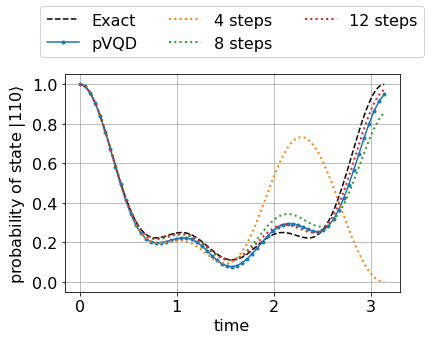

In [24]:
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(times,pvqd_ovps,label="pVQD",marker=".",color="C0")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i+1),label=str(t_n)+" steps",linewidth=2,linestyle="dotted")

plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
#plt.title(r'pVQD performance')
plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.35),ncol=3,fancybox=True)
plt.grid()
plt.show()

As can be seen, we have an improvement through the whole simulation, not just for the final state.
At $t \sim 1.5$ the Trotter approximation with $4$ steps starts detaching from the exact simulation, while the pVQD stay closer, with performances comparable to the 12 steps approximation.

We highlight that this technique is completely general: given a Trotter step $U(dt)$ we can compress its repeated application into a variational circuit of choice.

Moreover, this technique can also be performed entirely on hardware, as shown in [this article](https://arxiv.org/pdf/2112.12654.pdf).

In [25]:
#Here we show the parameters that we are going to use 
pvqd_opt_params = pvqd_params[-1]
pvqd_opt_params

[0.7840619877653185,
 0.5999999992029934,
 0.4159380122346803,
 1.4086623997672902,
 1.380475773411623,
 -0.5389980397024448,
 1.46781616276978,
 0.8556686027082773,
 -0.7040332003310628,
 2.2078027089580297,
 1.028508603283076,
 -1.2042851488956954,
 0.3699257134358077,
 2.2583060639524604,
 -1.1976539932840868,
 2.836564726172022,
 1.9145859975822752,
 -0.8580861044892956,
 0.47639486372158374,
 0.46141743253196066,
 -1.2172761180691782,
 3.372941222048196,
 2.2040606514312833,
 -3.066935438414977]

### 2.4 Final compression

In [21]:
## TODO: reduction to 15 CNOTs?

The circuit now has 24 CNOTs which is already very good, though it can be compressed even further! To this end we will be using the [Yang-Baxter Equation](https://www.worldscientific.com/doi/epdf/10.1142/S0217751X89001503) (YBE) which has recently been used by [Gulania et. al](https://arxiv.org/pdf/2112.01690.pdf) to compress the circuit for a Trotterized time evolution of the XY Heisenberg model. 

The YBE equation works in the following way:



In [37]:
# TODO: there is also a conjecture that we should cite.
# TODO: Import figure to illustrate the procedure, compute new variables variationally similar to the pVQD precedure (minimizing a local cost function).

We can use the `compute_overlap_and_gradient` function from pVQD to optimize the parameters for the YBE compressed circuit.

In [75]:
# Ansatz of the YBE compression

def Heisenberg_YBE_variational(num_qubits,p):

    circ = QuantumCircuit(num_qubits)
    count = 0
    
    def XYZ_variational(circ,i,j,params):
        circ.cx(i,j)
        circ.rx(params[0],i)
        circ.rx(-np.pi/2,i)
        circ.h(i)
        circ.rz(params[1],j)

        circ.cx(i,j)
        circ.h(i)
        circ.rz(params[2],j)

        circ.cx(i,j)
        circ.rx(np.pi/2,i)
        circ.rx(-np.pi/2,j)

    circ.rx(np.pi,[1,2])
    
    XYZ_variational(circ,1,2,p[count:count+3])
    count += 3
    XYZ_variational(circ,0,1,p[count:count+3])
    count += 3
    XYZ_variational(circ,1,2,p[count:count+3])
    count += 3
    XYZ_variational(circ,0,1,p[count:count+3])
    count += 3
    XYZ_variational(circ,1,2,p[count:count+3])
    count += 3

    return circ

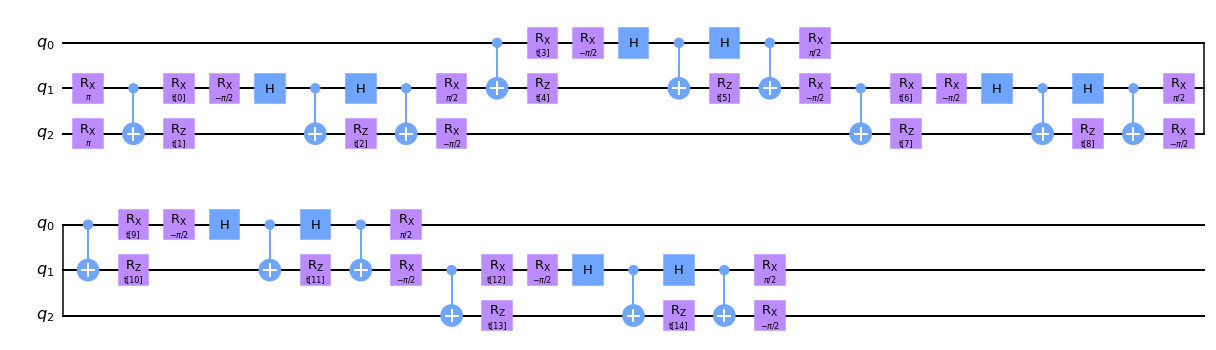

In [77]:
YBE_example = Heisenberg_YBE_variational(3,ParameterVector('t',15))

YBE_example.draw(output="mpl")

Now we learn the right parameters

In [44]:
l_ansatz       = Heisenberg_Trotter_variational(num_qubits,trotter_steps,pvqd_opt_params)
ybe_params_vec = ParameterVector('p',15)
r_ansatz       = Heisenberg_YBE_variational(num_qubits,ybe_params_vec)
right          = ParameterVector('r', 15)
r_circ         = r_ansatz.assign_parameters({ybe_params_vec: right})

ybe_parameters = np.asarray([-0.24161757786334437,
 0.29613735727758983,
 -0.19060774120362267,
 0.38535009511556434,
 0.04941420146395993,
 0.5131934897634404,
 -0.21751628521309574,
 -0.37861577782921546,
 0.3262810288625454,
 0.432306250241688,
 0.6472265455557861,
 0.5071853307927666,
 0.41004323080293875,
 0.28777917170766854,
 0.2855238243199889])#np.random.rand(15)

opt_steps      = 600
opt_ths        = 0.9999



# Then, create the total circuit
zero_prj   = StateFn(projector_zero(l_ansatz.num_qubits),is_measurement = True)
total_circ = r_circ+l_ansatz.inverse()
state_wfn  = expectation.convert(zero_prj @ StateFn(total_circ))

#total_circ.draw(output="mpl")

In [34]:
def overlap_and_gradient(right,state_wfn,parameters,expectator,sampler):

    nparameters = len(parameters)
    # build dictionary of parameters to values
    # {left[0]: parameters[0], .. ., right[0]: parameters[0] + shift[0], ...}
    # First create the dictionary for overlap
    values_dict = [dict(zip(right[:], parameters.tolist()))]


    # Then the values for the gradient
    for i in range(nparameters):
        values_dict.append(dict(zip(right[:] , (parameters  + ei(i,nparameters)*np.pi/2.0).tolist())))
        values_dict.append(dict(zip(right[:] , (parameters  - ei(i,nparameters)*np.pi/2.0).tolist())))

    # Now evaluate the circuits with the parameters assigned

    results = []

    for values in values_dict:
        sampled_op = sampler.convert(state_wfn,params=values)

        mean  = sampled_op.eval().real
        est_err = 0

        results.append([mean,est_err])
    
    E = np.zeros(2)
    g = np.zeros((nparameters,2))

    E[0],E[1] = results[0]

    for i in range(nparameters):
        rplus  = results[1+2*i]
        rminus = results[2+2*i]
        # G      = (Ep - Em)/2
        # var(G) = var(Ep) * (dG/dEp)**2 + var(Em) * (dG/dEm)**2
        g[i,:] = (rplus[0]-rminus[0])/2.0,np.sqrt(rplus[1]**2+rminus[1]**2)/2.0

    return E,g 

In [45]:
ybe_params = []
ybe_params.append(list(ybe_parameters))

num_parameters = len(ybe_parameters)
count = 0
overlap = [0.01,0]

# Initialise quantities for the Adam optimiser
m = np.zeros(num_parameters)
v = np.zeros(num_parameters)


while overlap[0] < opt_ths and count < opt_steps:
    print("Optimizing step:",count+1)
    count = count +1 

    ## Measure energy and gradient

    E,g = overlap_and_gradient(right,state_wfn,ybe_parameters,expectation,sampler)
    tot_steps = tot_steps+1


    print('Overlap',E[0])
    overlap = E
    #print('Gradient',g[:,0])


    meas_grad = np.asarray(g[:,0])
    ybe_parameters = np.asarray(adam_gradient(ybe_parameters,ybe_parameters,count,m,v,meas_grad))
    
    ybe_params.append(list(ybe_parameters))

# Update parameters

print('\n---------------------------------- \n')

print("New parameters:"        ,ybe_parameters)
print("New overlap: "          ,E[0])

Optimizing step: 1
Overlap 0.9599883487210834
Optimizing step: 2
Overlap 0.9603425682829584
Optimizing step: 3
Overlap 0.9606910274065955
Optimizing step: 4
Overlap 0.9610351767555321
Optimizing step: 5
Overlap 0.9613766702590616
Optimizing step: 6
Overlap 0.9617161125046254
Optimizing step: 7
Overlap 0.9620535949637693
Optimizing step: 8
Overlap 0.9623889807827004
Optimizing step: 9
Overlap 0.9627220424812541
Optimizing step: 10
Overlap 0.9630525840689136
Optimizing step: 11
Overlap 0.9633805217315893
Optimizing step: 12
Overlap 0.9637058951974159
Optimizing step: 13
Overlap 0.9640288159250275
Optimizing step: 14
Overlap 0.9643493956528991
Optimizing step: 15
Overlap 0.9646676993491411
Optimizing step: 16
Overlap 0.9649837350414745
Optimizing step: 17
Overlap 0.9652974704148389
Optimizing step: 18
Overlap 0.9656088615721846
Optimizing step: 19
Overlap 0.9659178809843011
Optimizing step: 20
Overlap 0.9662245343989269
Optimizing step: 21
Overlap 0.9665288610615016
Optimizing step: 22
Ov

Overlap 0.994645693985936
Optimizing step: 175
Overlap 0.9947408358415293
Optimizing step: 176
Overlap 0.9948349060705416
Optimizing step: 177
Overlap 0.9949279042201029
Optimizing step: 178
Overlap 0.9950198300049425
Optimizing step: 179
Overlap 0.9951106833125736
Optimizing step: 180
Overlap 0.9952004642082011
Optimizing step: 181
Overlap 0.9952891729393968
Optimizing step: 182
Overlap 0.9953768099404878
Optimizing step: 183
Overlap 0.9954633758366709
Optimizing step: 184
Overlap 0.9955488714478509
Optimizing step: 185
Overlap 0.9956332977921721
Optimizing step: 186
Overlap 0.9957166560892856
Optimizing step: 187
Overlap 0.9957989477632893
Optimizing step: 188
Overlap 0.9958801744454115
Optimizing step: 189
Overlap 0.9959603379763855
Optimizing step: 190
Overlap 0.9960394404085371
Optimizing step: 191
Overlap 0.9961174840076161
Optimizing step: 192
Overlap 0.9961944712543107
Optimizing step: 193
Overlap 0.9962704048455101
Optimizing step: 194
Overlap 0.9963452876952745
Optimizing ste

In [49]:
ybe_optimal = ybe_params[-1]

ybe_optimal 

[-0.38514469096164594,
 0.296137356965011,
 -0.3341348543018936,
 0.4087746636967923,
 -0.14818239756142565,
 0.28437027894552985,
 0.049329715010046946,
 -0.6303821572631807,
 0.6132068880919149,
 0.37223814597014065,
 0.7299930556349943,
 0.6397428971049554,
 0.21296820066194175,
 0.036992381902658335,
 0.0949709128475512]

In [42]:
ybe_params[0] ## Good starting point

[0.03373118677409992,
 0.2961373570877758,
 0.08474102343382095,
 0.2546320980482395,
 0.6364018125267661,
 0.6754325506249583,
 0.10598354211407146,
 0.2027557623316324,
 0.6566949196458212,
 0.19220683648957548,
 0.619115906917485,
 0.7261660833884045,
 0.9097403390051083,
 0.9757446242467671,
 0.7698724027069852]

## 3- Final Implementation

### 3.1 Error mitigation

Here we will use error mitigation to further improve the result. In particular we will be using Zero Noise Extrapolation (ZNE). For this the circuit depth is extended by unfolding gates, $G \rightarrow G G^\dagger G$. The circuit remains the same this way (since $G^\dagger G = I$), though the noise is increased. This way we can obtain results for different noise levels and extrapolate to the ideal, zero noise case. This prodecure is nicely wrapped into a single function provided by [mitiq](https://mitiq.readthedocs.io/en/stable/from). One simply has to be careful with minor bugs present in mitiq, we will comment on them below. 

In [78]:
# Define an ansatz for mitiq and also for the hardware

def final_circ(parameters):

    # Define the final circuit that is used to compute the fidelity 
    fqr = QuantumRegister(7)
    fqc = QuantumCircuit(fqr)
    #fqc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
    fqc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
    fqc.append(Heisenberg_YBE_variational(3,parameters), [fqr[1], fqr[3], fqr[5]])
    
    return fqc

In [102]:
# Define the final circuit that is used to compute the fidelity 
fqr = QuantumRegister(7)
fqc = QuantumCircuit(fqr)
#fqc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
fqc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
fqc.append(Heisenberg_YBE_variational(3,ybe_optimal), [fqr[1], fqr[3], fqr[5]])

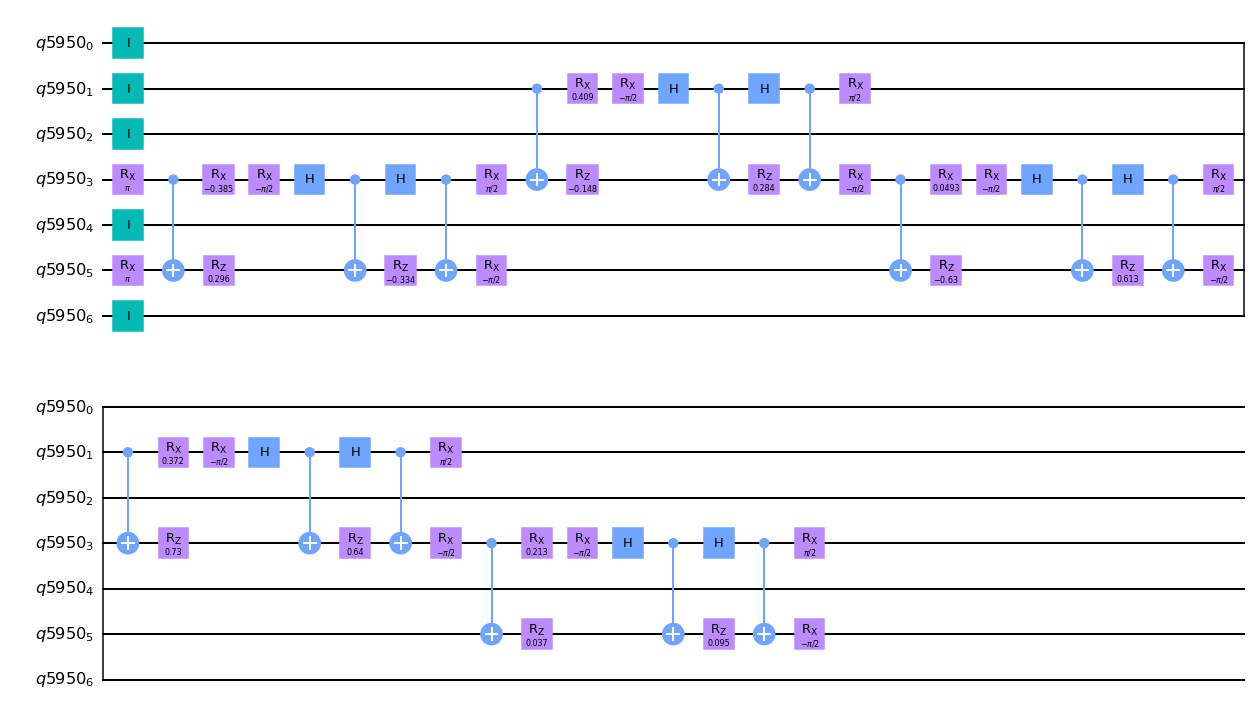

In [93]:
#fc = final_circ(ybe_optimal)

fc.decompose().draw(output="mpl")

In [56]:
from mitiq.zne.inference import PolyFactory
from mitiq.zne.zne import execute_with_zne

In [94]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-09 08:49:10,695: Credentials are already in use. The existing account in the session will be replaced.


In [95]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#jakarta = provider.get_backend('ibmq_jakarta')
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [96]:
# Setting all the parameters that are need
shots = 8192
backend = sim_noisy_jakarta

In [97]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

To use mitiq for noise mitigation we need to wrap the fidelity estimation via state tomography into a single "executor" function.

In [113]:
# Function that does state tomography and returns the fidelity
# To be used in the error mitigation (mitq)
def executor(circ):
    
    # Create list of state tomography circuits out of circ
    st_qcs = state_tomography_circuits(circ, [circ.qubits[1], circ.qubits[3], circ.qubits[5]])

    # Execute the state tomography circuits 
    job = execute(st_qcs, backend, optimization_level=3, shots=shots)
    print('Job ID', job.job_id())
    
    return state_tomo(job.result(), st_qcs)

In [104]:
# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0], order=2)

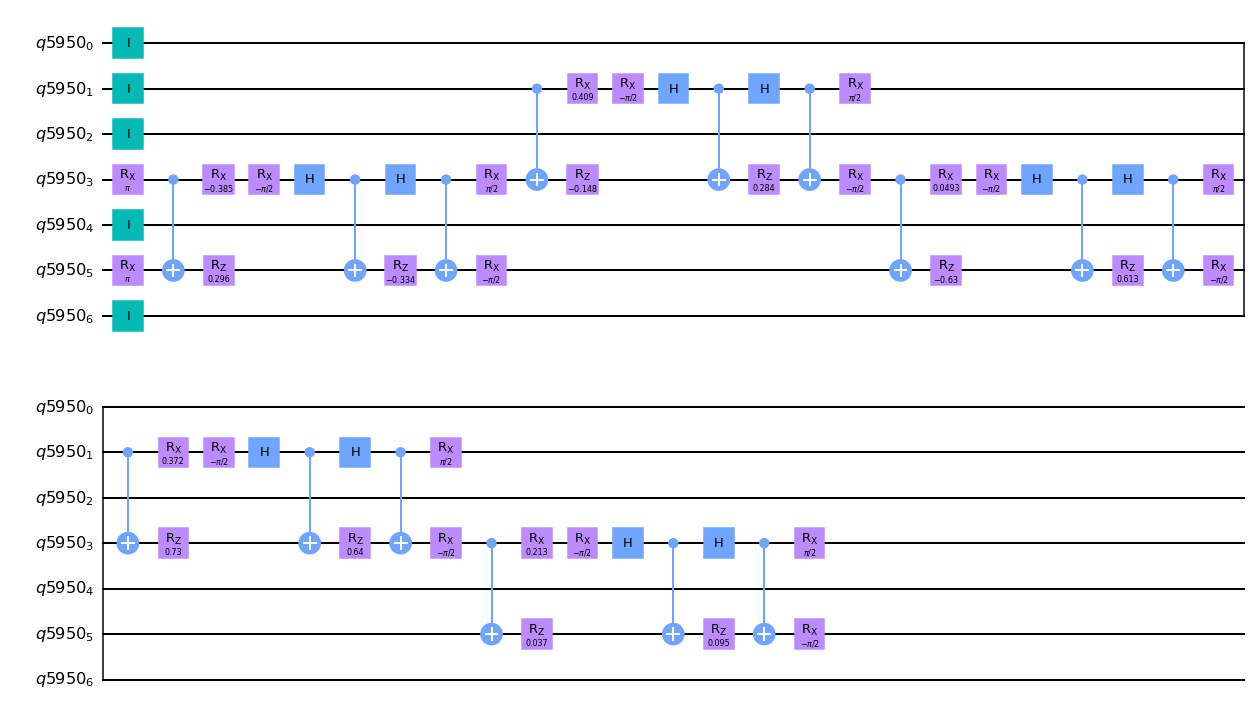

In [105]:
fc.decompose().draw("mpl")

In [114]:
executor(fqc)

Job ID 7c426f47-8ff3-4a3b-96f4-2fe8af36259f


0.7988916460375546

In [115]:
# Repeat fidelity measurement
reps = 2 # Needs to be 8 in the final execution
fids = []
for _ in range(reps):
    
    # Circuit needs to be decomposed for mitq
    fids.append(execute_with_zne(fc.decompose(), executor, factory=poly_fac)) 

Job ID 617dcd2a-736a-459c-bf38-d9eaf996a149
Job ID 89674ca4-fc20-4efa-9977-23f13940aa44
Job ID f7c5b949-d445-4f02-b055-c3782b7d1299
Job ID d89f2c52-1e69-4f90-ad3d-e9554cc289ca
Job ID ea114b0f-2c91-46e4-86c9-d95e813c4fe0
Job ID aaa8b555-4ef6-4c46-bba2-bd040088f9eb


In [116]:
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.7980 ± 0.0010
